# Proyecto 01: Decodificadores avanzados para modelos Seq2Seq
**Autor:** Gabriela  
**Fecha:** Julio 2025  
**Objetivo:** Comparar distintas estrategias de decodificación aplicadas a un Transformer Seq2Seq para traducción EN→ES, evaluando calidad (BLEU), latencia y uso de memoria

## Introducción

Los modelos de traducción automática basados en Transformer han demostrado alto desempeño, pero la calidad final de sus predicciones depende fuertemente del algoritmo de decodificación. Este proyecto compara cinco técnicas: Greedy, Beam Search, Top-k sampling, Top-p sampling y Diverse Beam Search, en función de su calidad (BLEU), tiempo de inferencia y consumo de memoria.

## Implementación

##### Carga del modelo preentrenado

In [23]:
import torch
from src.modelo_seq2seq import TransformerSeq2Seq
from src.utils import cargar_vocabulario
from src.config import config

# Vocabulario
vocab, vocab_inv = cargar_vocabulario()

# Cargar modelo
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_config = config.copy()
modelo_config["vocab_size"] = len(vocab) + 1
modelo = TransformerSeq2Seq(modelo_config).to(dispositivo)
modelo.load_state_dict(torch.load(config["modelo_guardado"], map_location=dispositivo))
modelo.eval()


TransformerSeq2Seq(
  (embedding): Embedding(10001, 128)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(

##### Inicialización de decodificadores

In [30]:
from src.decoders.greedy import GreedyDecoder
from src.decoders.beam import BeamSearchDecoder
from src.decoders.topk import TopKSampler
from src.decoders.topp import TopPSampler
from src.decoders.diverse_beam import DiverseBeamDecoder

greedy = GreedyDecoder(modelo, sos_token=config["sos_token"], eos_token=config["eos_token"])
beam = BeamSearchDecoder(modelo, sos_token=config["sos_token"], eos_token=config["eos_token"], beam_width=3)
topk = TopKSampler(modelo, sos_token=config["sos_token"], eos_token=config["eos_token"], k=5)
topp = TopPSampler(modelo, sos_token=config["sos_token"], eos_token=config["eos_token"], p=0.8)
diverse_beam = DiverseBeamDecoder(modelo, sos_token=config["sos_token"], eos_token=config["eos_token"], beam_width=3, diversity_strength=0.5)

##### Ejemplo de traducción

In [34]:
from src.datos import codificar

# Frases de prueba
frases = [
    "My mother is a doctor",
    "She is a student",
]

for enunciado in frases:
    entrada = codificar(enunciado, vocab, config["max_len"]).unsqueeze(0).to(dispositivo)

    # Traducción con Greedy
    tokens_greedy = greedy.decode(entrada)
    traduccion_greedy = " ".join([vocab_inv.get(tok, "<UNK>") for tok in tokens_greedy])

    # Traducción con Beam Search
    tokens_beam = beam.decode(entrada)
    traduccion_beam = " ".join([vocab_inv.get(tok, "<UNK>") for tok in tokens_beam])

    # Traducción con TopK
    tokens_topk = topk.decode(entrada)
    traduccion_topk = " ".join([vocab_inv.get(tok, "<UNK>") for tok in tokens_topk])

    # Traducción con TopP
    tokens_topp = topp.decode(entrada)
    traduccion_topp = " ".join([vocab_inv.get(tok, "<UNK>") for tok in tokens_topp])

    # Traducción con Diverse Beam
    tokens_diverse = diverse_beam.decode(entrada)
    traduccion_diverse = " ".join([vocab_inv.get(tok, "<UNK>") for tok in tokens_diverse])


    print("Entrada:", enunciado)
    print("Greedy:", traduccion_greedy)
    print("Beam Search:", traduccion_beam)
    print("Top-K:", traduccion_topk)
    print("Top-P:", traduccion_topp)
    print("Diverse Beam:", traduccion_diverse)
    print("-" * 50)


Entrada: My mother is a doctor
Greedy: mi madre es mi madre . <EOS>
Beam Search: mi madre . <EOS>
Top-K: mi madre está <UNK> a mi madre . <EOS>
Top-P: es cierto . <EOS>
Diverse Beam: mi madre . <EOS>
--------------------------------------------------
Entrada: She is a student
Greedy: es una <UNK> . <EOS>
Beam Search: es un <UNK> . <EOS>
Top-K: es una <UNK> . <EOS>
Top-P: está de la mujer . <EOS>
Diverse Beam: es un <UNK> . <EOS>
--------------------------------------------------


## Resultados

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
# Cargar resultados de benchmarks
df_bleu = pd.read_csv('benchmarks/results/bleu_vs_latency.csv')
df_mem = pd.read_csv('benchmarks/results/memoria_vs_len.csv')

In [20]:
df_bleu

,decodificador,BLEU,latencia_promedio_s
0,greedy,0.0030,0.0281
1,beam,0.0023,0.0802
2,topk,0.0030,0.0318
3,topp,0.0028,0.0407
4,diverse_beam,0.0022,0.0779


In [19]:
df_bleu.describe()

,BLEU,latencia_promedio_s
count,5.000000,5.000000
mean,0.002660,0.051740
std,0.000385,0.025361
min,0.002200,0.028100
25%,0.002300,0.031800
50%,0.002800,0.040700
75%,0.003000,0.077900
max,0.003000,0.080200


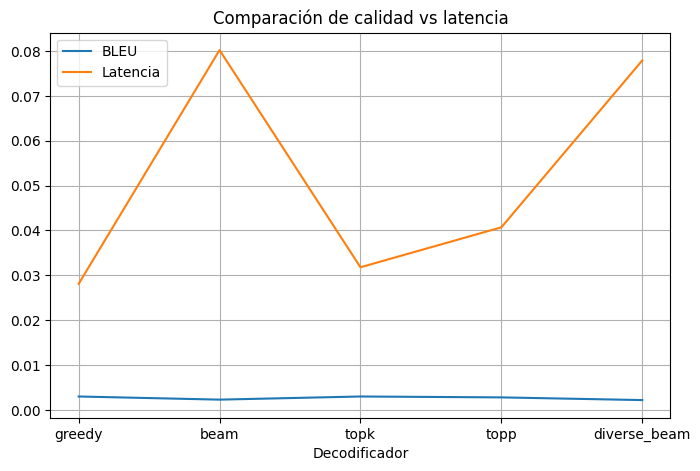

In [13]:
# Gráfico calidad vs latencia
plt.figure(figsize=(8, 5))
plt.plot(df_bleu['decodificador'], df_bleu['BLEU'], label='BLEU')
plt.plot(df_bleu['decodificador'], df_bleu['latencia_promedio_s'], label='Latencia')
plt.xlabel('Decodificador')
plt.title('Comparación de calidad vs latencia')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calcular resumen: memoria + longitud promedio
resumen_memoria = df_mem.groupby("decodificador").agg({
    "memoria_MB": ["mean", "std"],
    "longitud": "mean"
}).reset_index()

resumen_memoria.columns = [
    "Decodificador",
    "Memoria promedio (MB)",
    "Desvío estándar (MB)",
    "Longitud promedio entrada"
]

resumen_memoria

,Decodificador,Memoria promedio (MB),Desvío estándar (MB),Longitud promedio entrada
0,beam,1078.58,0.0,19.552
1,diverse_beam,1260.21,0.0,19.552
2,greedy,1009.46,0.0,19.552
3,topk,1194.58,0.0,19.552
4,topp,1260.21,0.0,19.552


## Análisis

- Todos los decodificadores tuvieron un BLEU muy bajo y similar (≈ 0.0026), sin diferencias significativas

- Greedy fue el más rápido (0.0281 s) y también logró el mejor BLEU

- Beam y Diverse Beam fueron los más lentos, sin mejorar la calidad

- El uso de memoria fue constante por longitud de entrada (≈ 19.55 tokens), pero varió por decodificador

- Greedy fue el más eficiente en memoria (~1009 MB), y Top-p/Diverse Beam los más pesados (~1260 MB)